In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from local_feature_tutorial.wbs import *
from local_feature_tutorial.visualization import *
from local_feature_tutorial.io import *
from local_feature_tutorial.datasets import *
from wbs_tutorial.SP import *
import cv2
import os
from copy import deepcopy
import torchvision as tv
from PIL import Image
import shlex
#export
import pydegensac
import torch
import sys
sys.path.insert(0, './megadepth/')
import numpy as np
from options.train_options import TrainOptions
from data.data_loader import CreateDataLoader
from models.models import create_model
from skimage import io
from skimage.transform import resize

from scene_info import SceneInfo
from depth_to_normals import compute_normals_simple_diff_convolution, get_megadepth_file_names_and_dir, megadepth_input_dir
from dataclasses import dataclass
from rectification import possibly_upsample_normals, get_rectified_keypoints
from connected_components import get_connected_components, show_components
from utils import Timer
from pathlib import Path
from matching import match_images_and_keypoints
from evaluation import compare_poses, Stats
from config import Config

import numpy as np
import cv2 as cv
from scene_info import read_cameras, read_images, SceneInfo



cameras = read_cameras("scene2")
images = read_images("scene2")

scene_info = SceneInfo.read_scene('scene2')


class degensac_VerifierH(GeometricVerifier):
    def __init__(self, th = 0.5):
        self.th = th
        return
    def verify(self, srcPts:np.array, dstPts:np.array):
        F, mask = pydegensac.findHomography(srcPts, dstPts, self.th, 0.999, max_iters=250000)
        return F, mask
sift_matcher = TwoViewMatcher(detector=cv2.SIFT_create(8000, edgeThreshold=10000), 
                              descriptor=RootSIFT(),
                              matcher= SNNMMatcher(0.95),
                              geom_verif=degensac_Verifier(0.5))


angle distance in rad used for k_means in radians: 0.609385308030795
the same in degrees: 34.91520624744419
reading scene info starting
reading scene info finished. It took 4.74251389503479


In [3]:
fname1='/home/old-ufo/datasets/StrongViewpointChangesDataset/scene2/images/frame_0000001005_1.jpg'
fname2='/home/old-ufo/datasets/StrongViewpointChangesDataset/scene2/images/frame_0000000620_1.jpg'




In [ ]:
res1 = sift_matcher.verify(fname1,fname2)


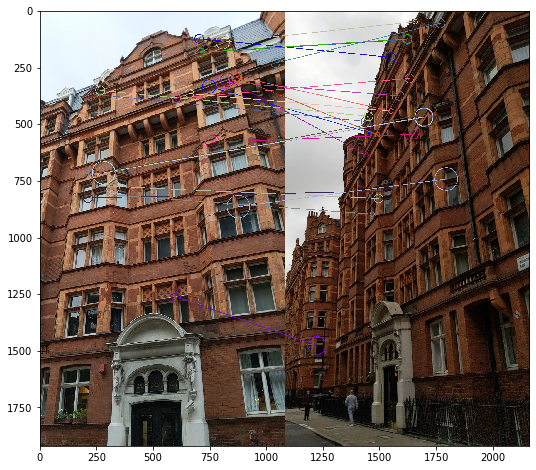

In [3]:
draw_matches(res1['match_kpts1'], res1['match_kpts2'],
            cv2.cvtColor(cv2.imread(fname1), cv2.COLOR_BGR2RGB),
            cv2.cvtColor(cv2.imread(fname2), cv2.COLOR_BGR2RGB), R=10, vert=False)


In [9]:
from mit_semseg.config import cfg
from mit_semseg.dataset import TestDataset
from mit_semseg.models import ModelBuilder, SegmentationModule
def get_nonsky_mask(fname, semseg_model = None):
    if semseg_model is None:
        import os
        if not os.path.isdir('.semseg'):
            !mkdir .semseg
            !cd .semseg && wget http://sceneparsing.csail.mit.edu/model/pytorch/ade20k-resnet18dilated-ppm_deepsup/decoder_epoch_20.pth
            !cd .semseg && wget http://sceneparsing.csail.mit.edu/model/pytorch/ade20k-resnet18dilated-ppm_deepsup/encoder_epoch_20.pth
        net_encoder = ModelBuilder.build_encoder(
            arch='resnet18dilated',
            fc_dim=512,
            weights='.semseg/encoder_epoch_20.pth')
        net_decoder = ModelBuilder.build_decoder(
            arch='ppm_deepsup',
            fc_dim=512,
            num_class=150,
            weights='.semseg/decoder_epoch_20.pth',
            use_softmax=True)

        crit = torch.nn.NLLLoss(ignore_index=-1)
        segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
        segmentation_module.eval()
        semseg_model = segmentation_module
    semseg_model = semseg_model.cuda()
    pil_to_tensor = tv.transforms.Compose([
        tv.transforms.Resize((512, 384)),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
            std=[0.229, 0.224, 0.225])  # across a large photo dataset.
    ])
    pil_image = Image.open(fname).convert('RGB')
    img_original = np.array(pil_image)
    img_data = pil_to_tensor(pil_image)
    singleton_batch = {'img_data': img_data[None].cuda()}
    output_size = img_data.shape[1:]
    # Run the segmentation at the highest resolution.
    with torch.no_grad():
        scores = semseg_model(singleton_batch, segSize=output_size)
        # Get the predicted scores for each pixel
        _, pred = torch.max(scores, dim=1)
        pred = pred.detach().cpu()[0].numpy()
        nonsky_mask = pred!=2
    return nonsky_mask

    
    
def get_depth_map(fname, model = None):
    if model is None:
        sys.argv = ['']
        opt = TrainOptions().parse()
        opt.display_id = 0
        opt.checkpoints_dir = './megadepth/checkpoints/'
        model = create_model(opt)
        model.netG = model.netG.cuda()
    input_height = 384
    input_width  = 512
    img = np.float32(io.imread(fname))/255.0
    img = resize(img, (input_height, input_width), order = 1)
    input_img =  torch.from_numpy( np.transpose(img, (2,0,1)) ).contiguous().float()
    input_img = input_img.unsqueeze(0)
    with torch.no_grad():
        input_images = input_img.cuda() 
        pred_log_depth = model.netG.forward(input_images) 
        pred_log_depth = torch.squeeze(pred_log_depth)
        pred_depth = torch.exp(pred_log_depth)
    return pred_depth.detach().cpu().numpy()

In [3]:
import kornia.feature as KF
import numpy as np
import torch
import pydegensac
from kornia_moons.feature import *

In [21]:
def process_img(img_name, scene_info = None, rectify=False, zeroout_sky=True):
    feature_descriptor = cv.SIFT_create(8000) 
    Timer.start_check_point("processing img")
    print("Processing: {}".format(img_name))
    if scene_info is not None:
        img_file_path = scene_info.get_img_file_path(img_name)
    else:
        img_file_path = img_name
    img = cv.cvtColor(cv.imread(img_file_path, None), cv.COLOR_BGR2RGB)
    if scene_info is not None:
        K = scene_info.get_img_K(img_name)
    else:
        K = np.eye(3)
        h, w = img.shape[:2] 
        K[0, 0] = (h+w)/2.0
        K[1, 1] = (h+w)/2.0
        K[0, 2] = w/2.0
        K[1, 2] = h/2.0
    if rectify:

        # depth => indices
        normals_dir = 'normals'
        depth_input_dir = 'out_depth'

        output_directory = "{}/{}".format(normals_dir, img_name)
        depth_fname = f'{depth_input_dir}/{img_name}.npy'
        if not os.path.isdir(depth_input_dir):
            os.makedirs(depth_input_dir)
        if not os.path.isfile(depth_fname):
            depth_map = get_depth_map(img_file_path)
            if zeroout_sky:
                nonsky_mask = get_nonsky_mask(img_file_path)
                depth_without_sky = depth_map * resize(nonsky_mask, depth_map.shape)
            else:
                depth_without_sky = depth_map
            np.save(depth_fname, depth_without_sky)
        normals, normal_indices = compute_normals_simple_diff_convolution(scene_info  if scene_info is not None else float(K[1, 1]), 
                                                                         depth_input_dir, 
                                                                          "{}.npy".format(img_name), 
                                                                          True, output_directory)
        # TODO - shouldn't the normals be persisted already with the connected components?

        # normal indices => cluster indices (maybe safe here?)
        normal_indices = possibly_upsample_normals(img, normal_indices)
        components_indices, valid_components_dict = get_connected_components(normal_indices,
                                                                             range(len(normals)),
                                                                             True)
        if False:#self.show_clustered_components:
            show_components(components_indices, valid_components_dict.keys())

        # get rectification
        kps, descs = get_rectified_keypoints(normals,
                                             components_indices,
                                             valid_components_dict
                                             , img, K, descriptor=feature_descriptor
                                             , img_name=img_name)
    else:
        kps, descs = feature_descriptor.detectAndCompute(img, None)

    Timer.end_check_point("processing img")
    return img, K, kps, descs

In [22]:
def match_and_show_inliers(img1, img2, kps1, kps2, descs1, descs2):
    
    dists, idxs = KF.match_smnn(torch.from_numpy(descs1), torch.from_numpy(descs2), 0.9)
    tentatives = cv2_matches_from_kornia(dists, idxs)
    print (len(tentatives))
    src_pts = np.float32([ kps1[m.queryIdx].pt for m in tentatives ]).reshape(-1,2)
    dst_pts = np.float32([ kps2[m.trainIdx].pt for m in tentatives ]).reshape(-1,2)
    F, inliers_mask = pydegensac.findFundamentalMatrix(src_pts, dst_pts, 0.75, 0.99, 100000)
    draw_params = dict(matchColor = (255,255,0), # draw matches in yellow color
                   singlePointColor = None,
                   matchesMask = inliers_mask.ravel().tolist(), # draw only inliers
                   flags = 2)
    img_out = cv2.drawMatches(img1,kps1,img2,kps2,tentatives,None,**draw_params)
    plt.figure()
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(img_out, interpolation='nearest')
    print (f'{inliers_mask.sum()} inliers found')
    return tentatives, inliers_mask

processing img starting
Processing: frame_0000001005_1
------------ Options -------------
batchSize: 1
beta1: 0.5
checkpoints_dir: ./checkpoints/
continue_train: False
display_freq: 100
display_id: 1
display_winsize: 256
fineSize: 256
gpu_ids: [0, 1]
identity: 0.0
input_nc: 3
isTrain: True
lambda_A: 10.0
lambda_B: 10.0
loadSize: 286
lr: 0.0002
max_dataset_size: inf
model: pix2pix
nThreads: 2
name: test_local
ndf: 64
ngf: 64
niter: 100
niter_decay: 100
no_flip: False
no_html: False
no_lsgan: False
norm: instance
output_nc: 3
phase: train
pool_size: 50
print_freq: 100
save_epoch_freq: 5
save_latest_freq: 5000
serial_batches: False
use_dropout: False
which_epoch: latest
which_model_netG: unet_256
-------------- End ----------------
===========================================LOADING Hourglass NETWORK====================================================
./megadepth/checkpoints/test_local/best_generalization_net_G.pth
model [HGModel] was created


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Creating dir (if not exists already): normals/frame_0000001005_1


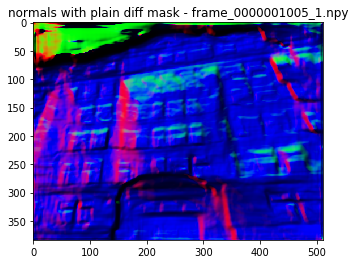

clustering normals starting


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


clustering normals finished. It took 1.5904700756072998


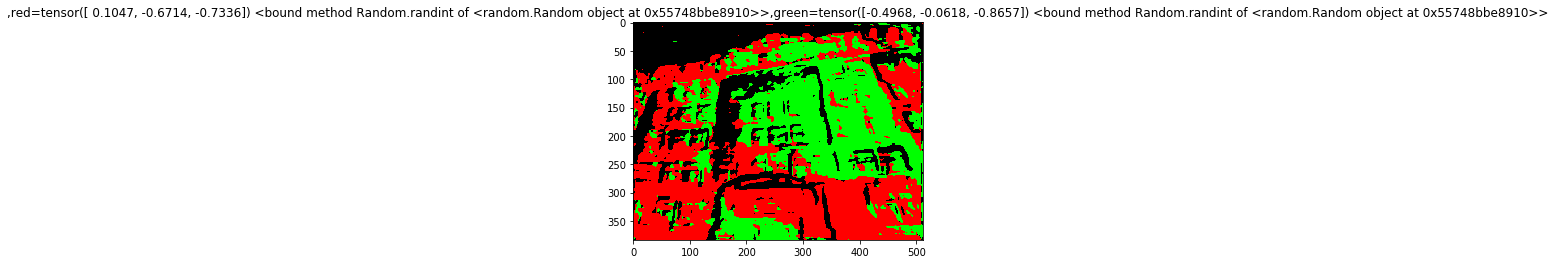

Will upsample the normals


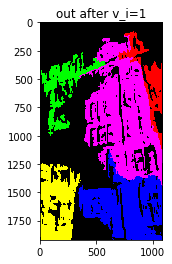

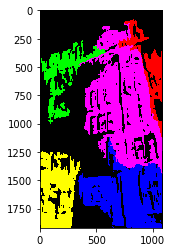

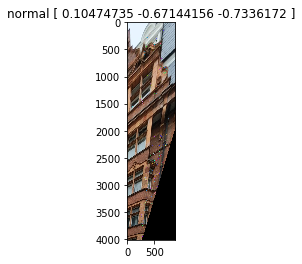

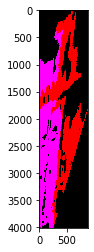

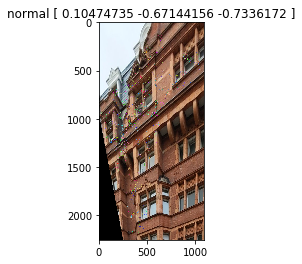

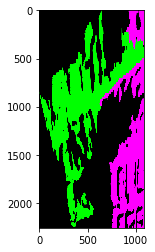

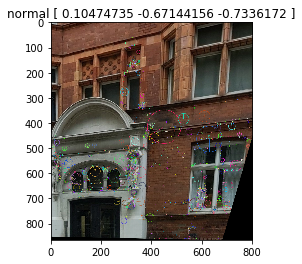

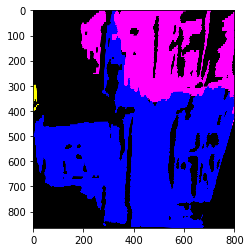

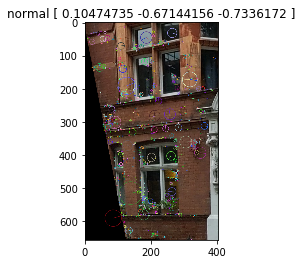

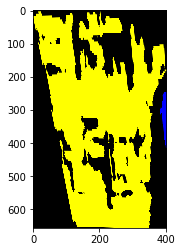

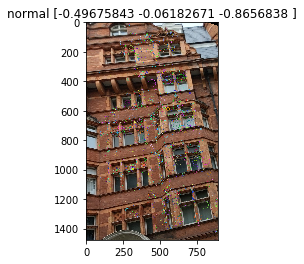

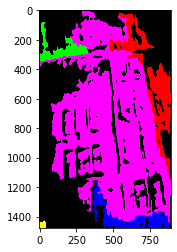

processing img finished. It took 14.080353736877441
processing img starting
Processing: frame_0000000620_1
------------ Options -------------
batchSize: 1
beta1: 0.5
checkpoints_dir: ./checkpoints/
continue_train: False
display_freq: 100
display_id: 1
display_winsize: 256
fineSize: 256
gpu_ids: [0, 1]
identity: 0.0
input_nc: 3
isTrain: True
lambda_A: 10.0
lambda_B: 10.0
loadSize: 286
lr: 0.0002
max_dataset_size: inf
model: pix2pix
nThreads: 2
name: test_local
ndf: 64
ngf: 64
niter: 100
niter_decay: 100
no_flip: False
no_html: False
no_lsgan: False
norm: instance
output_nc: 3
phase: train
pool_size: 50
print_freq: 100
save_epoch_freq: 5
save_latest_freq: 5000
serial_batches: False
use_dropout: False
which_epoch: latest
which_model_netG: unet_256
-------------- End ----------------
===========================================LOADING Hourglass NETWORK====================================================
./megadepth/checkpoints/test_local/best_generalization_net_G.pth
model [HGModel] was cre

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Creating dir (if not exists already): normals/frame_0000000620_1


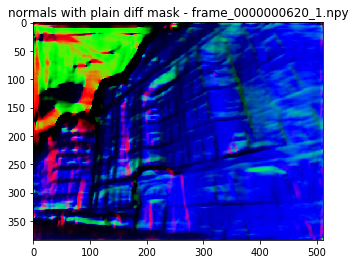

clustering normals starting


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


clustering normals finished. It took 1.6638319492340088


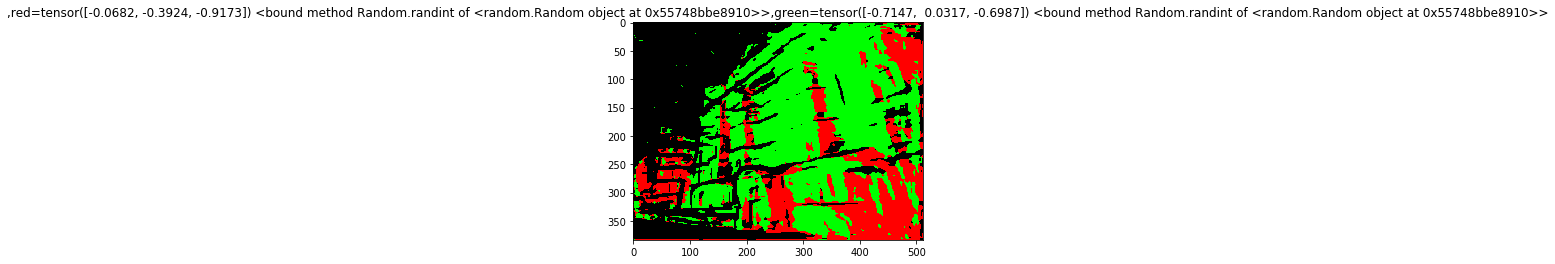

Will upsample the normals


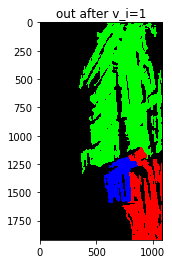

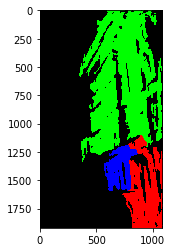

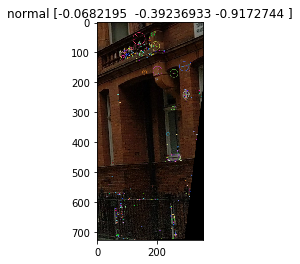

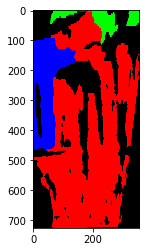

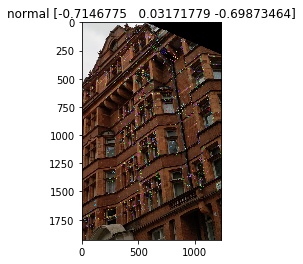

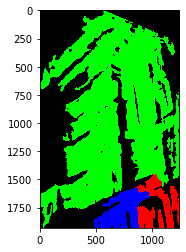

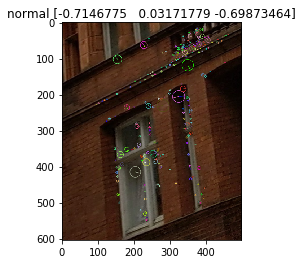

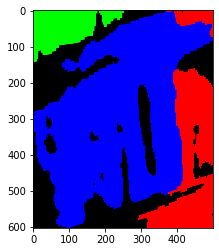

processing img finished. It took 8.258558750152588


In [24]:
img1, K1, kps1, descs1 = process_img('frame_0000001005_1', scene_info, True, False)
img2, K2, kps2, descs2 = process_img('frame_0000000620_1', scene_info, True, False)


In [25]:
img1, K1, kps1_no, descs1_no = process_img('frame_0000001005_1', scene_info, False, False)
img2, K2, kps2_no, descs2_no = process_img('frame_0000000620_1', scene_info, False, False)


processing img starting
Processing: frame_0000001005_1
processing img finished. It took 0.576401948928833
processing img starting
Processing: frame_0000000620_1
processing img finished. It took 0.5870993137359619


296
26 inliers found
395
14 inliers found


<Figure size 432x288 with 0 Axes>

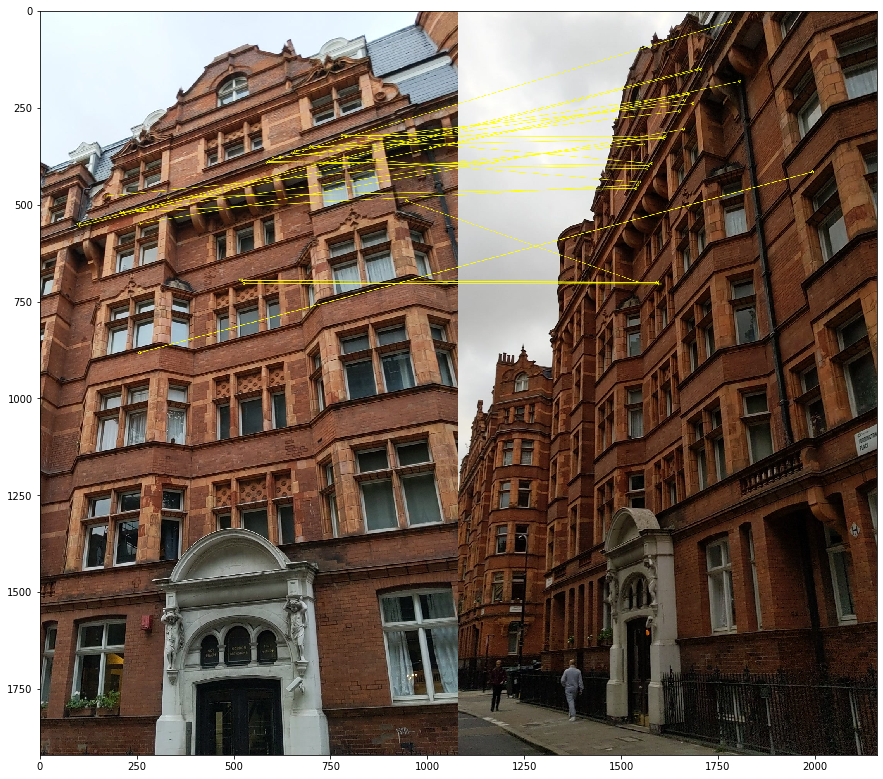

<Figure size 432x288 with 0 Axes>

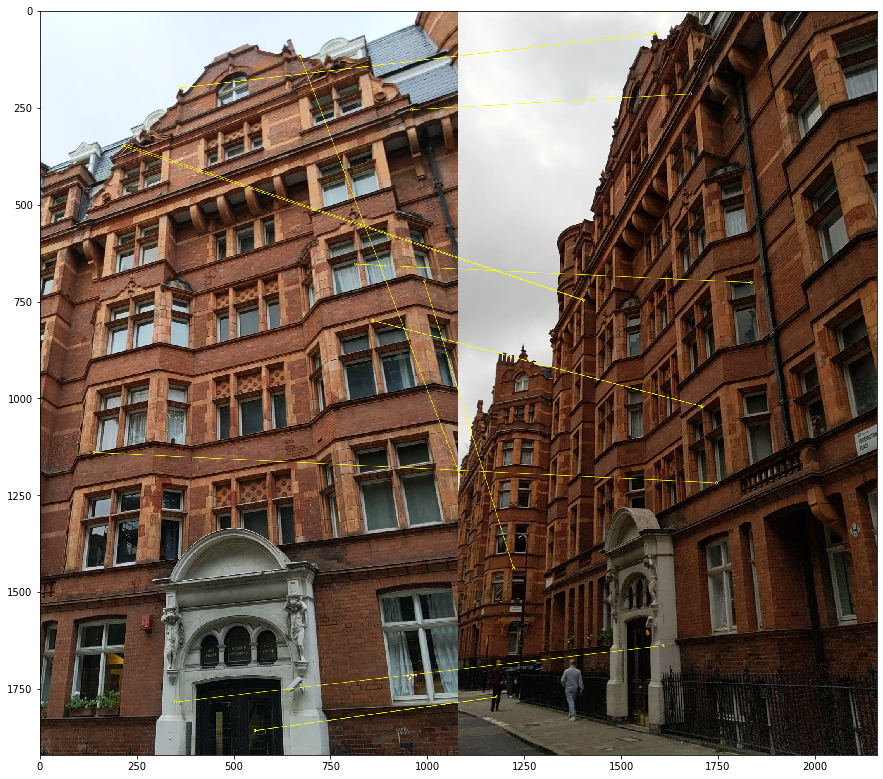

In [26]:
tentatives, inliers_mask = match_and_show_inliers(img1, img2, kps1, kps2, descs1, descs2)
tentatives_no, inliers_mask_no = match_and_show_inliers(img1, img2, kps1_no, kps2_no, descs1_no, descs2_no)


In [19]:
if not os.path.isfile('kn_church-2.jpg'):
    !wget https://github.com/kornia/kornia-examples/raw/master/data/matching/kn_church-2.jpg
    !wget https://github.com/kornia/kornia-examples/raw/master/data/matching/kn_church-8.jpg

processing img starting
Processing: kn_church-2.jpg
------------ Options -------------
batchSize: 1
beta1: 0.5
checkpoints_dir: ./checkpoints/
continue_train: False
display_freq: 100
display_id: 1
display_winsize: 256
fineSize: 256
gpu_ids: [0, 1]
identity: 0.0
input_nc: 3
isTrain: True
lambda_A: 10.0
lambda_B: 10.0
loadSize: 286
lr: 0.0002
max_dataset_size: inf
model: pix2pix
nThreads: 2
name: test_local
ndf: 64
ngf: 64
niter: 100
niter_decay: 100
no_flip: False
no_html: False
no_lsgan: False
norm: instance
output_nc: 3
phase: train
pool_size: 50
print_freq: 100
save_epoch_freq: 5
save_latest_freq: 5000
serial_batches: False
use_dropout: False
which_epoch: latest
which_model_netG: unet_256
-------------- End ----------------
===========================================LOADING Hourglass NETWORK====================================================
./megadepth/checkpoints/test_local/best_generalization_net_G.pth
model [HGModel] was created


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Creating dir (if not exists already): normals/kn_church-2.jpg


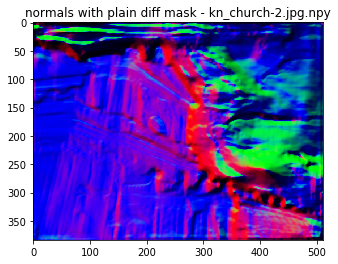

clustering normals starting


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


clustering normals finished. It took 0.8880841732025146


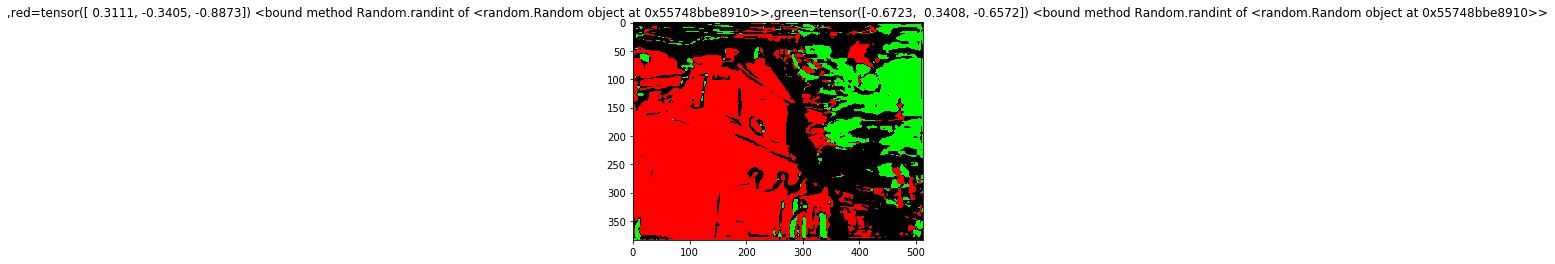

Will upsample the normals


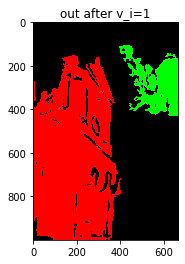

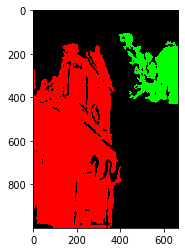

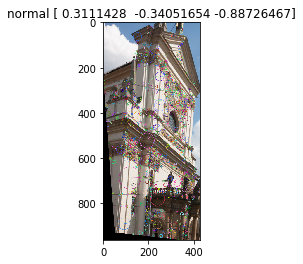

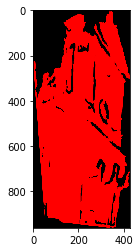

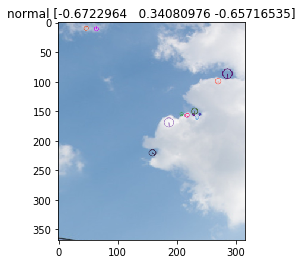

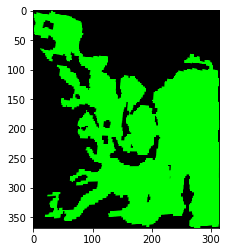

processing img finished. It took 4.863354682922363
processing img starting
Processing: kn_church-8.jpg
------------ Options -------------
batchSize: 1
beta1: 0.5
checkpoints_dir: ./checkpoints/
continue_train: False
display_freq: 100
display_id: 1
display_winsize: 256
fineSize: 256
gpu_ids: [0, 1]
identity: 0.0
input_nc: 3
isTrain: True
lambda_A: 10.0
lambda_B: 10.0
loadSize: 286
lr: 0.0002
max_dataset_size: inf
model: pix2pix
nThreads: 2
name: test_local
ndf: 64
ngf: 64
niter: 100
niter_decay: 100
no_flip: False
no_html: False
no_lsgan: False
norm: instance
output_nc: 3
phase: train
pool_size: 50
print_freq: 100
save_epoch_freq: 5
save_latest_freq: 5000
serial_batches: False
use_dropout: False
which_epoch: latest
which_model_netG: unet_256
-------------- End ----------------
===========================================LOADING Hourglass NETWORK====================================================
./megadepth/checkpoints/test_local/best_generalization_net_G.pth
model [HGModel] was created

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Creating dir (if not exists already): normals/kn_church-8.jpg


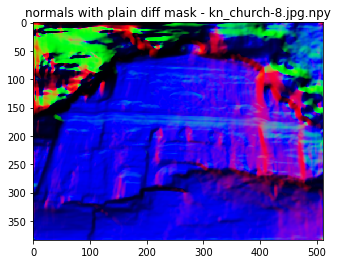

clustering normals starting


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


clustering normals finished. It took 1.8188481330871582


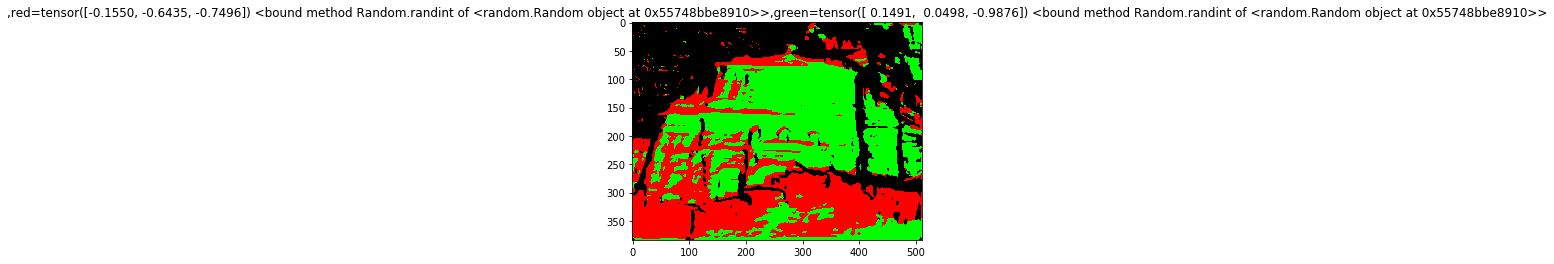

Will upsample the normals


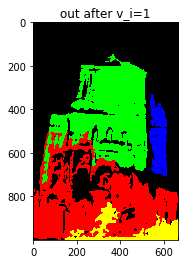

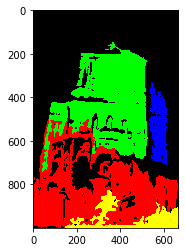

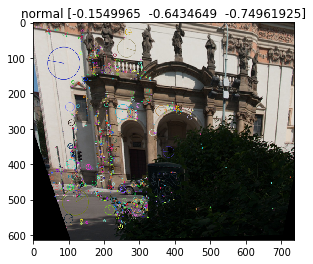

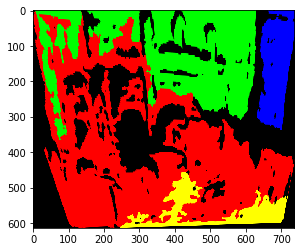

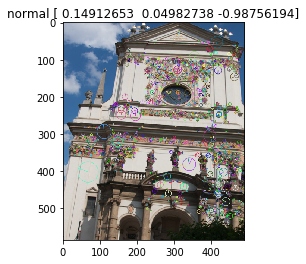

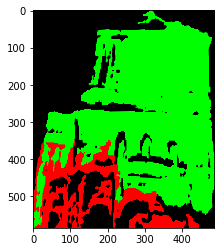

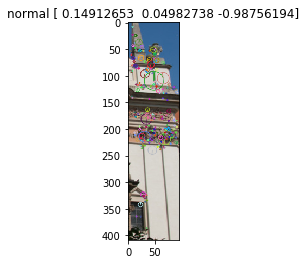

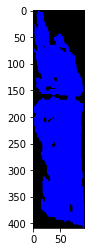

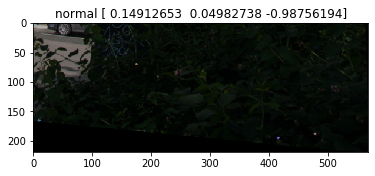

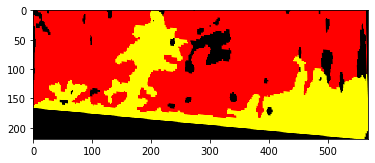

processing img finished. It took 7.254859209060669


In [27]:
img1, K1, kps1, descs1 = process_img('kn_church-2.jpg', None, True, False)
img2, K2, kps2, descs2 = process_img('kn_church-8.jpg', None, True, False)


In [28]:
img1, K1, kps1_no, descs1_no = process_img('kn_church-2.jpg', None, False)
img2, K2, kps2_no, descs2_no = process_img('kn_church-8.jpg', None, False)


processing img starting
Processing: kn_church-2.jpg
processing img finished. It took 0.17892026901245117
processing img starting
Processing: kn_church-8.jpg
processing img finished. It took 0.1634509563446045


148
13 inliers found
192
16 inliers found


<Figure size 432x288 with 0 Axes>

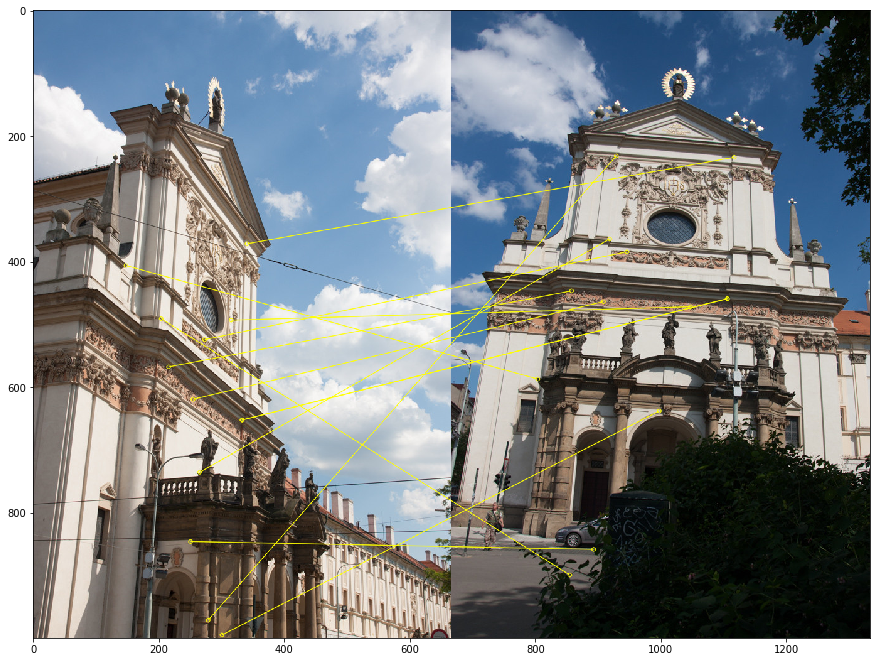

<Figure size 432x288 with 0 Axes>

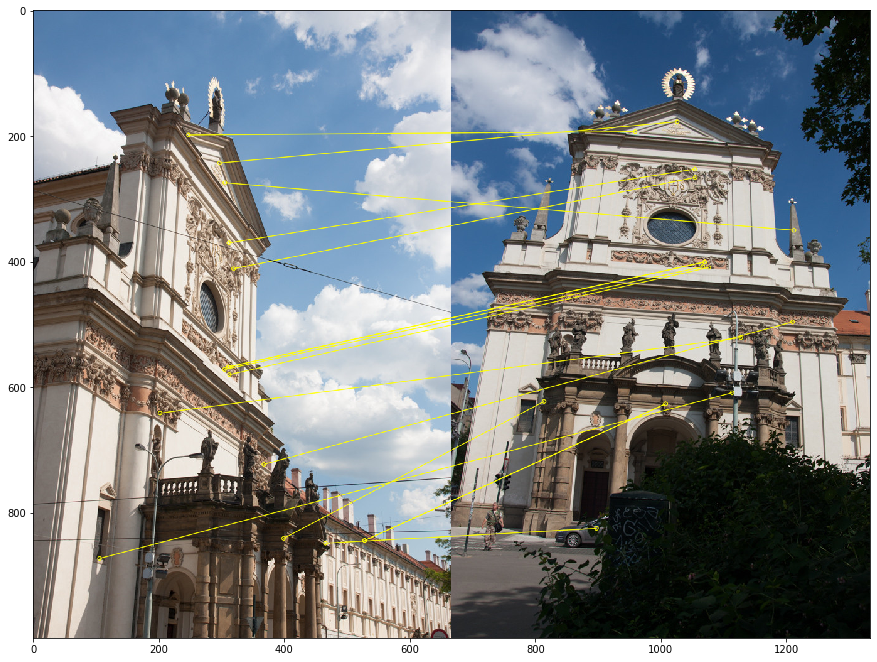

In [29]:
tentatives, inliers_mask = match_and_show_inliers(img1, img2, kps1, kps2, descs1, descs2)
tentatives_no, inliers_mask_no = match_and_show_inliers(img1, img2, kps1_no, kps2_no, descs1_no, descs2_no)
